In [230]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats


In [231]:
data = pd.read_csv("cleaned_US_Accidents.csv", index_col=0)
print(data.columns)
features = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
            'Pressure(in)', 'Wind_Speed(mph)']

severity_mask = data['Severity'] != 0
n = severity_mask.sum()
data = data[severity_mask]


Index(['Severity', 'State', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Weather_Condition_Score'],
      dtype='object')


### Basic Severity Analysis

0.9999999999999999


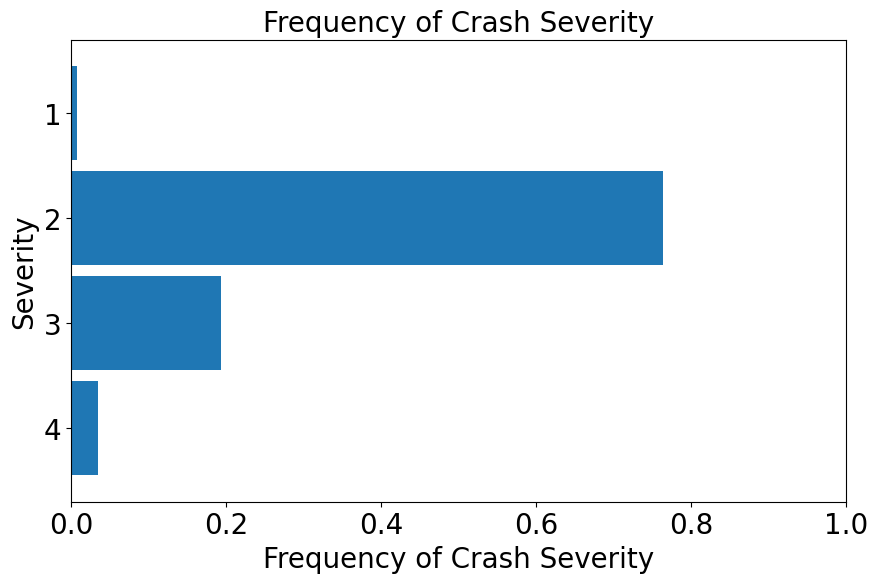

In [232]:
counts = data['Severity'].value_counts().sort_index(ascending=False) / n
print(counts.sum())

counts.plot(kind='barh', stacked=True, figsize=(10,6), width=0.9)
plt.ylabel("Counts", fontsize=20)
plt.xlim((0, 1))
plt.xlabel("Frequency of Crash Severity", fontsize=20)
plt.ylabel("Severity")
plt.title("Frequency of Crash Severity", fontsize=20)
plt.tick_params(axis='both', labelsize=20)

### Oversampling

target_size = 100000
samples = []

for _, data_class in data.groupby("Severity"):
    if data_class.shape[0] < 200000:
        over = data_class.sample(target_size, replace=True, random_state=42)
        samples.append(over)
    else:
        samples.append(data_class)

data = pd.concat(samples).sample(frac=1, random_state=42).reset_index(drop=True)

### Weather Analysis

In [220]:
def remove_outliers(data, feature):
    Q1, Q3 = np.quantile(data[feature], 0.25), np.quantile(data[feature], 0.75)
    IQR = Q3 - Q1
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    
    mask = np.logical_and(data[feature] >= lower, data[feature] <= upper)
    data = data[mask]
    return data

def plot_box_plot(data, feature, title, ax):
    plt.sca(ax)
    data.plot.box(column=feature, by='Severity', 
                flierprops={'markerfacecolor': 'k', 'markersize': 5},
                ax = ax, 
                color = dict(boxes='k', whiskers='k', medians='r', caps='k'),
                boxprops=dict(linewidth=5),          # Linewidth for the box
                whiskerprops=dict(linewidth=5),      # Linewidth for the whiskers
                medianprops=dict(linewidth=5), # Linewidth and color for the median
                capprops=dict(linewidth=5))
    
    plt.xlabel('Severity', fontsize=40)
    plt.ylabel(feature, fontsize=40)
    plt.title("", fontsize=40)
    ax.tick_params(axis='both', labelsize=40)

def run_ANOVA(data, feature):
    grouped_data = data.groupby("Severity")
    groups = [group[feature] for _, group in grouped_data]
    f_stat, p_value = stats.f_oneway(*groups)
    return p_value
    

ANOVA p value: 0.0
ANOVA p value: 0.0
ANOVA p value: 1.196440176958561e-104
ANOVA p value: 0.0
ANOVA p value: 2.8186610462072865e-182


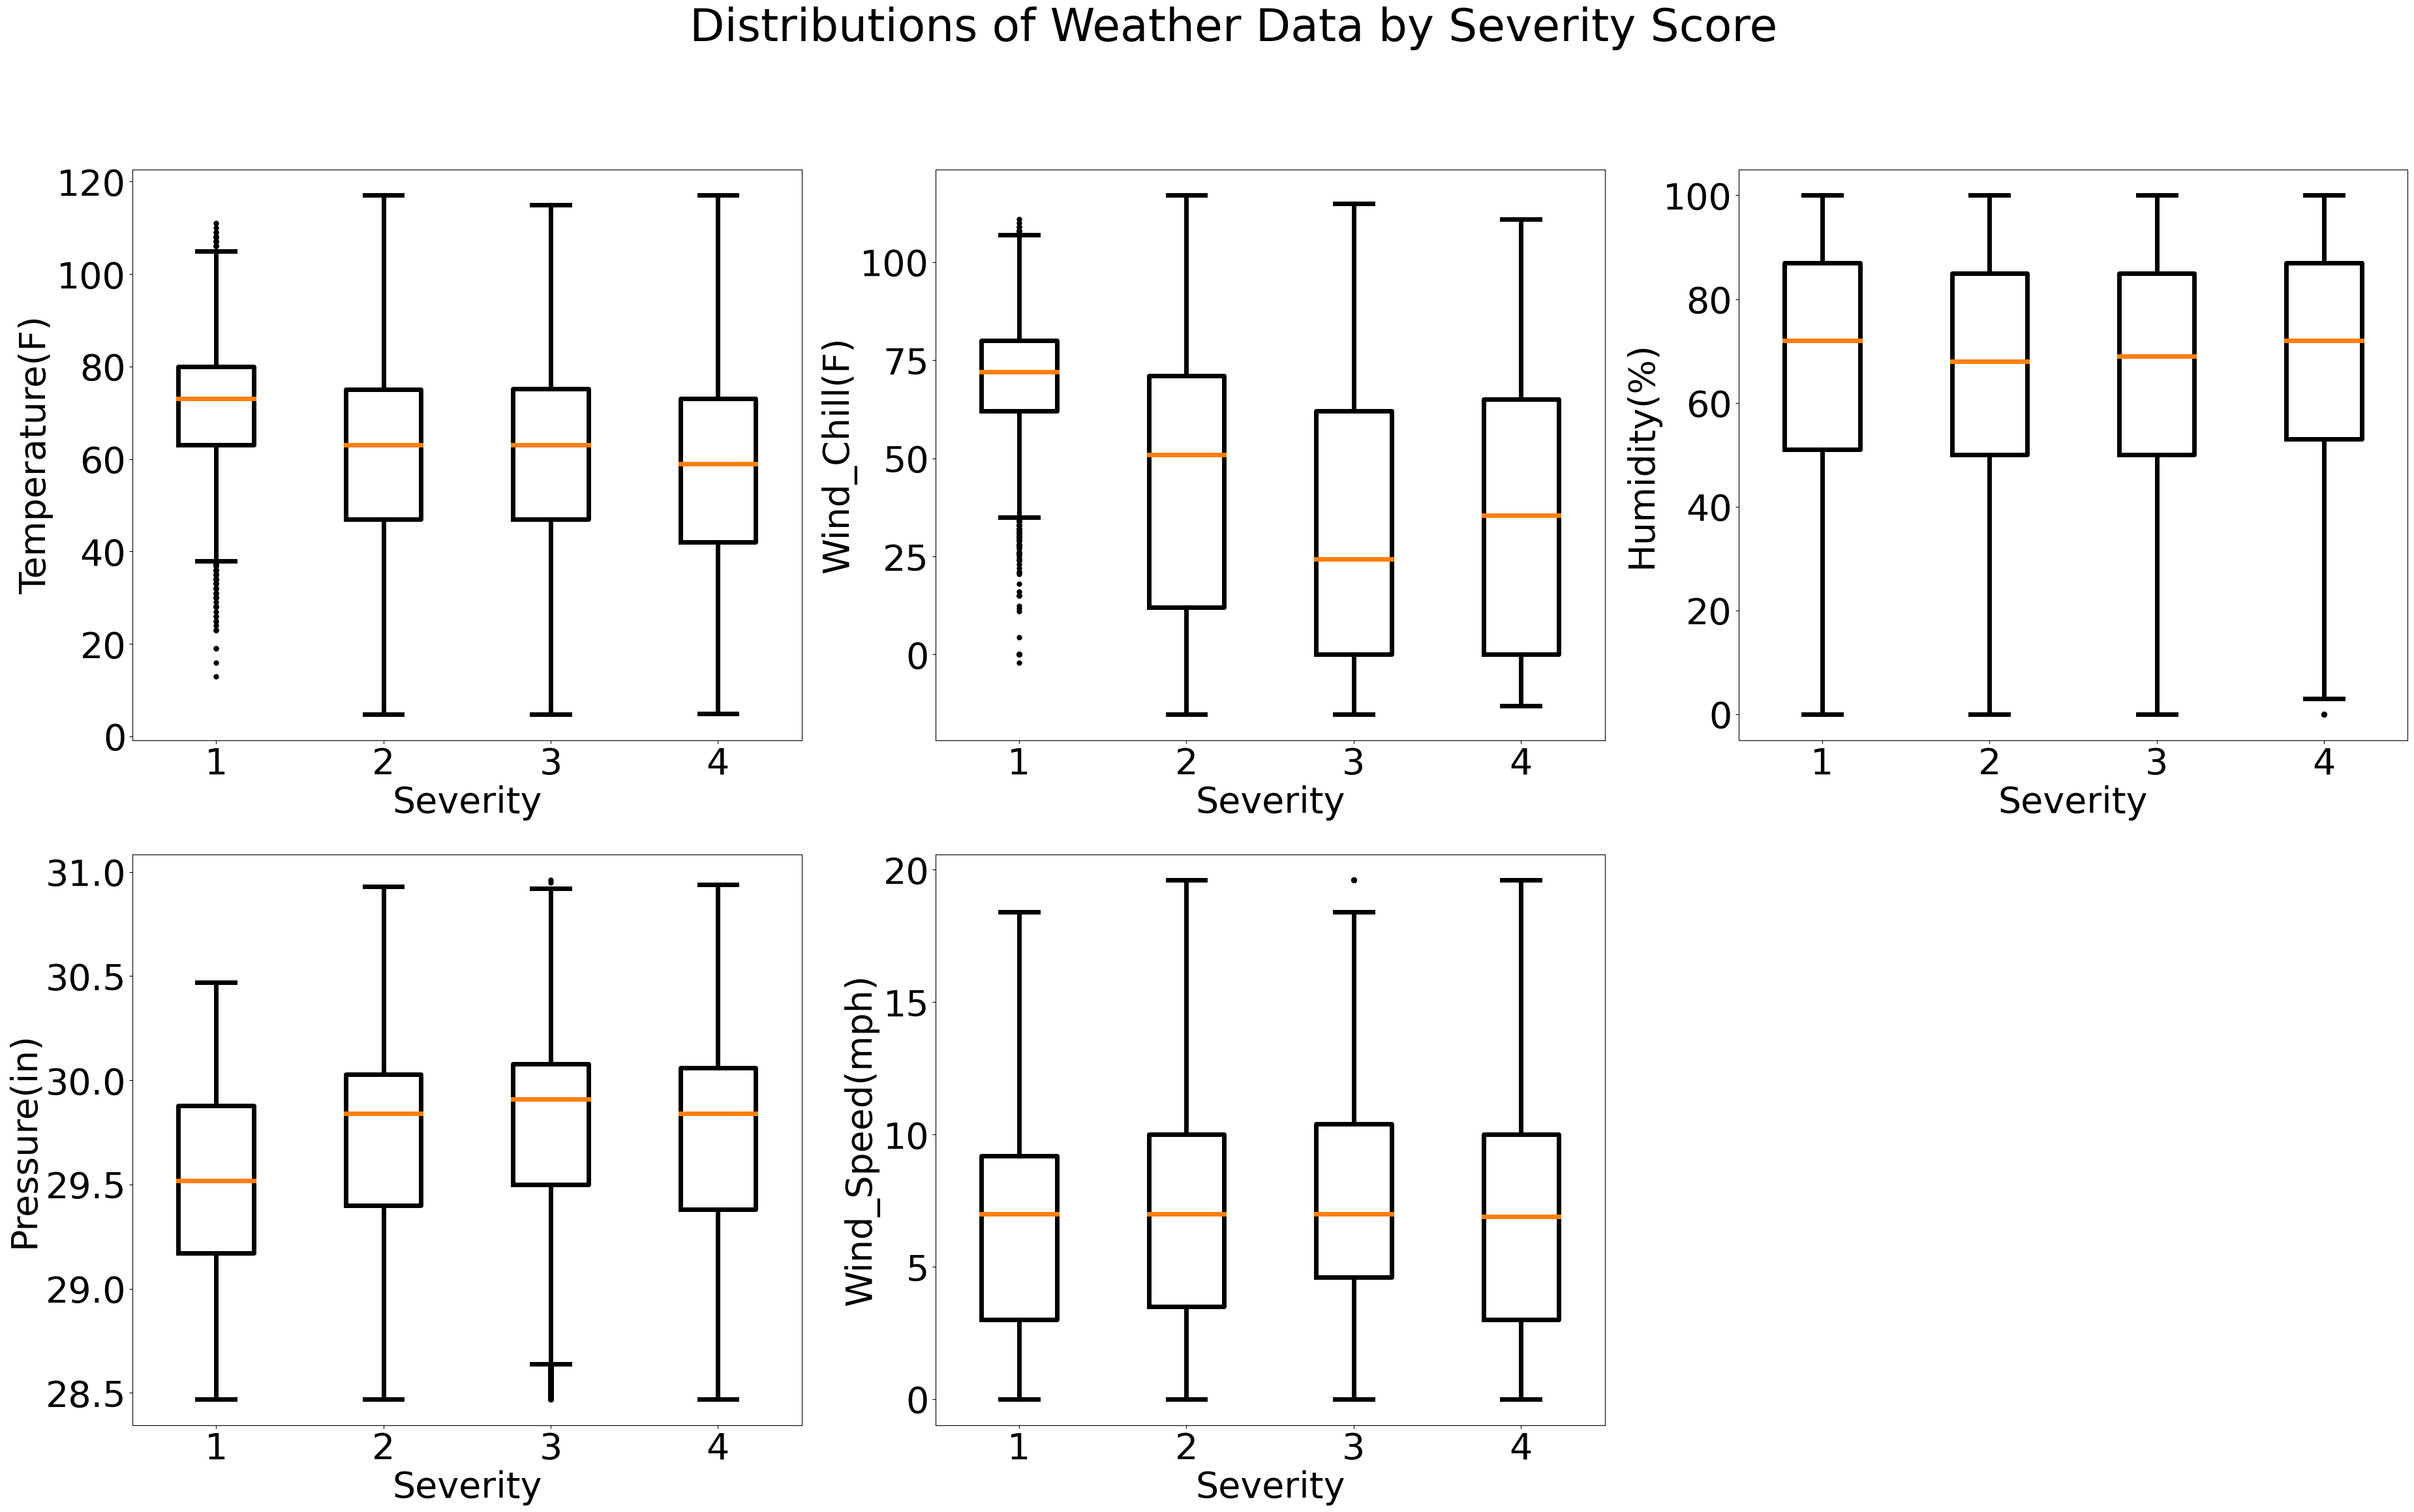

In [224]:
for feature in features:
    data = remove_outliers(data, feature)
    print(f"ANOVA p value: {run_ANOVA(data, feature)}")

figure, axes = plt.subplots(2, 3, figsize=(45, 25))
figure.suptitle("Distributions of Weather Data by Severity Score", fontsize=50)
axes = axes.ravel()
axes[-1].remove()

for i, feature in enumerate(features):
    ax = axes[i]
    plot_box_plot(data, feature, title=feature, ax=ax)


In [180]:
data.groupby("Severity")["Pressure(in)"].describe()

,count,mean,std,min,25%,50%,75%,max
Severity,,,,,,,,
1,8233.0,28.747761,3.127693,0.0,28.91,29.38,29.84,30.47
2,754928.0,28.947709,3.893883,0.0,29.22,29.77,30.01,58.63
3,191457.0,29.115142,3.915162,0.0,29.39,29.88,30.07,31.12
4,34088.0,28.635083,4.669726,0.0,29.12,29.75,30.03,30.98


### Weather Analysis

Severity                  1         2         3         4
Weather_Condition                                        
0                  0.008568  0.766646  0.190514  0.034271
1                  0.006494  0.743993  0.213123  0.036390
2                  0.007125  0.717138  0.242930  0.032806


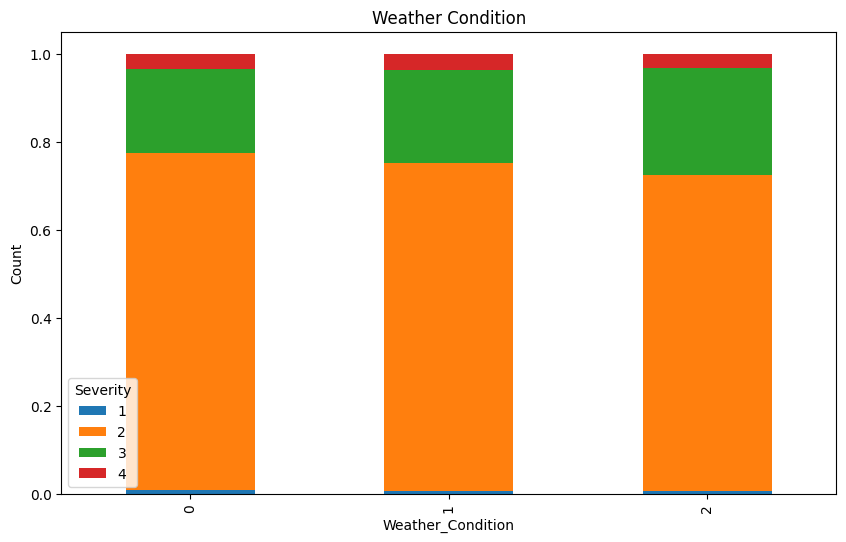

In [185]:
features = ['Weather_Condition', 'Amenity', 'Bump', 'Crossing',
            'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
            'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

counts = data.groupby('Weather_Condition')['Severity'].value_counts().unstack(fill_value=0)
row_props = counts.div(counts.sum(axis=1), axis=0)
print(row_props)

row_props.plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel("Count")
plt.title("Weather Condition")
plt.show()

In [212]:
features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
            'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
            'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

df = data.groupby("Severity")
summary = {1: [], 2: [], 3: [], 4: []}

for _, group in df:
    severity = group['Severity'].values[0]
    for feature in features:
        mask = group[features] == 1
        amount = mask.sum()
        summary[severity].append(amount)

result_df = pd.DataFrame.from_dict(summary)
print(result_df.head())
        
    




                                                   1  \
0  Amenity             187
Bump                  ...   
1  Amenity             187
Bump                  ...   
2  Amenity             187
Bump                  ...   
3  Amenity             187
Bump                  ...   
4  Amenity             187
Bump                  ...   

                                                   2  \
0  Amenity             11824
Bump                ...   
1  Amenity             11824
Bump                ...   
2  Amenity             11824
Bump                ...   
3  Amenity             11824
Bump                ...   
4  Amenity             11824
Bump                ...   

                                                   3  \
0  Amenity              650
Bump                 ...   
1  Amenity              650
Bump                 ...   
2  Amenity              650
Bump                 ...   
3  Amenity              650
Bump                 ...   
4  Amenity              650
Bump              

{'Amenity': 0.014081031165988677, 'Bump': 0.00043390047192997717, 'Crossing': 0.11463468412247928, 'Give_Way': 0.005614409136790917, 'Junction': 0.07478461746970283, 'No_Exit': 0.0026023914085683713, 'Railway': 0.007958887677428882, 'Roundabout': 4.7536881540114045e-05, 'Station': 0.02509037064607679, 'Stop': 0.026433540405337887, 'Traffic_Calming': 0.0010114230114917882, 'Traffic_Signal': 0.15543043129100056, 'Turning_Loop': 0.0}
0.4281232236883361


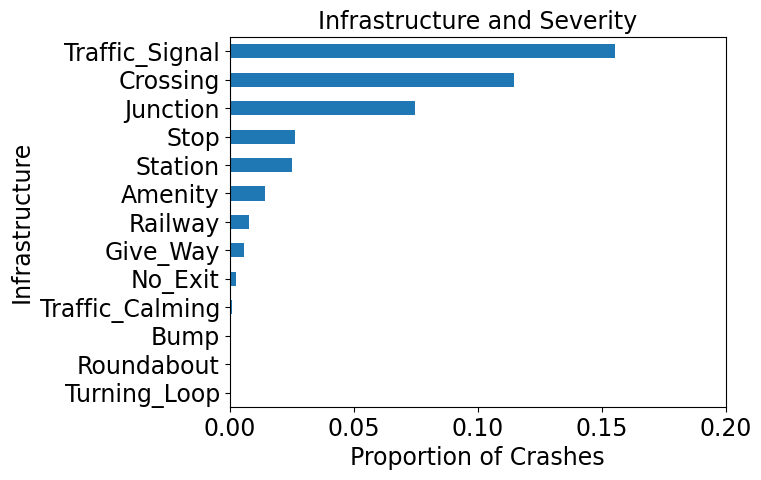

In [183]:
features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
            'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
            'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

df = data[features]
summary = {}

for feature in features:
    mask = df[feature] == 1
    feature_amount = data[mask].shape[0]
    props = feature_amount / n
    summary[feature] = props

print(summary)

summary_df = pd.Series(summary).fillna(0).sort_values(ascending=True)  # features as rows
print(summary_df.sum())

summary_df.plot.barh()
plt.xlim((0, .2))
plt.xlabel("Proportion of Crashes", fontsize=17)
plt.ylabel("Infrastructure", fontsize=17)
plt.title("Infrastructure and Severity", fontsize=17)
plt.tick_params(axis='both', labelsize=17)